## Models on the Sphere



In [1]:
import numpy as np
from quagmire import QuagMesh 
from quagmire import tools as meshtools
from mpi4py import MPI

import lavavu
import stripy
comm = MPI.COMM_WORLD

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# from scipy.ndimage.filters import gaussian_filter

/Users/lmoresi/opt/anaconda3/envs/quagmire/lib/python3.7/site-packages/h5py/__init__.py:40: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.10.5, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


lons, lats, simplices = global_CO_mesh("icosahedral_mesh", refinement_C=4, refinement_O=1, include_face_points=True)

In [4]:
lons, lats, simplices = meshtools.global_CO_mesh("icosahedral_mesh", refinement_C=6, refinement_O=2, include_face_points=True)

stN - (39210,) x (39210,)
stN - (39210,) x (39210,)


In [5]:
lats.shape, lons.shape

((39210,), (39210,))

In [8]:
dm = meshtools.create_spherical_DMPlex(lons, lats, simplices, refinement_levels=3)

In [9]:
mesh = QuagMesh(dm, downhill_neighbours=2)

# Mark up the shadow zones

rank = np.ones((mesh.npoints,))*comm.rank
shadow = np.zeros((mesh.npoints,))

# get shadow zones
shadow_zones = mesh.lgmap_row.indices < 0
shadow[shadow_zones] = 1
shadow_vec = mesh.gvec.duplicate()

mesh.lvec.setArray(shadow)
mesh.dm.localToGlobal(mesh.lvec, shadow_vec, addv=True)

rawheight = mesh.add_variable(name="height", locked=False)
rainfall = mesh.add_variable(name="rain", locked=False)
runoff_var = mesh.add_variable(name="runoff", locked=False)

print("{} mesh points".format(mesh.npoints))

Underlying Mesh type: sTriMesh
0 - Delaunay triangulation 5.07690616s
0 - Calculate node weights and area 0.8648180679999982s
0 - Find boundaries 0.0441078019999992s
0 - cKDTree 0.5596625800000012s
0 - Construct neighbour cloud arrays 20.83707438700001s, (12.248698911000005s + 8.588334392s)
0 - Construct rbf weights 3.442367290000007s
2509314 mesh points


In [78]:
rawheight = mesh.add_variable(name="height", locked=False)
rawheight.data = mesh_height

In [10]:
mesh.save_mesh_to_hdf5("test.h5")

In [11]:
## Read ETOPO1 data from online service
#
# Note the slicing is a mix of the data range and the integer step

import xarray

etopo_dataset = "http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/ETOPO1_Bed_g_gmt4.nc"
etopo_data = xarray.open_dataset(etopo_dataset)
etopo_coarse = etopo_data.sel(x=slice(-180.0,180.0,3), y=slice(-90.0,90.0,3))

lons = etopo_coarse.coords.get('x')
lats = etopo_coarse.coords.get('y')
vals = etopo_coarse['z']

x,y = np.meshgrid(lons.data, lats.data)
height = 6.370 + 1.0e-6 * vals.data 

In [12]:
mesh_height = meshtools.map_global_raster_to_strimesh(mesh, height)
with mesh.deform_topography():
    mesh.topography.data = mesh_height
    


0 - Build downhill matrices 4.811452333999995s
0 - Build upstream areas 10.703238722999998s


In [13]:
# runoff  "/thredds/wcs/agg_terraclimate_q_1958_CurrentYear_GLOBE.nc"

from owslib.wcs import WebCoverageService
# import gdal

url = "http://thredds.northwestknowledge.net:8080/thredds/wcs/agg_terraclimate_ppt_1958_CurrentYear_GLOBE.nc"
wcs = WebCoverageService(url, version='1.0.0')
for layer in list(wcs.contents):
    print("Layer Name:", layer)
    print("Title:", wcs[layer].title, '\n')
    
output = wcs.getCoverage(identifier=layer,
                    service="WCS", bbox=[-180, -90, 180, 90], 
                    resx = 1800.0 / 3600.0, resy = 1800.0 / 3600.0,
                    format='geotiff')

with open("GlobalRainfall.tif", "wb") as f:
    f.write(output.read())
    
# Read it back and reduce the size of the array

url = "http://thredds.northwestknowledge.net:8080/thredds/wcs/agg_terraclimate_q_1958_CurrentYear_GLOBE.nc"
wcs = WebCoverageService(url, version='1.0.0')
for layer in list(wcs.contents):
    print("Layer Name:", layer)
    print("Title:", wcs[layer].title, '\n')
    
output = wcs.getCoverage(identifier=layer,
                    service="WCS", bbox=[-180, -90, 180, 90], 
                    resx = 1800.0 / 3600.0, resy = 1800.0 / 3600.0,
                    format='geotiff')

with open("GlobalRunoff.tif", "wb") as f:
    f.write(output.read())
    

Layer Name: station_influence
Title: station_influence 

Layer Name: ppt
Title: precipitation_amount 

Layer Name: q
Title: runoff_amount 



In [14]:
import imageio
rain = imageio.imread("GlobalRainfall.tif")[::3,::3].astype(float)
runoff = imageio.imread("GlobalRunoff.tif")[::3,::3].astype(float)

[cols, rows] = rain.shape
print([cols,rows])

rlons = np.linspace(-180,180, rows)
rlats = np.linspace(-180,180, cols)

rx,ry = np.meshgrid(rlons.data, rlats.data)


rainfall.data  = np.maximum(0.0,meshtools.map_global_raster_to_strimesh(mesh, rain[::-1,:]))
runoff_var.data  = np.maximum(0.0,meshtools.map_global_raster_to_strimesh(mesh, runoff[::-1,:]))

[1440, 2880]


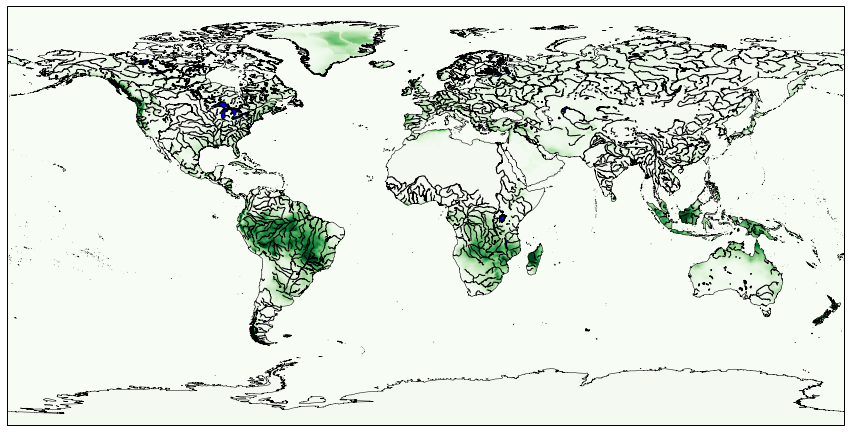

In [15]:

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                           edgecolor="green",
                           facecolor="blue")

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                           edgecolor="green",
                           facecolor="blue")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                           edgecolor="green",
                           facecolor="blue")

map_extent = ( -180, 180, -90, 90 )

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)
ax.add_feature(lakes,     edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="black", facecolor="none", linewidth=1, zorder=3)

plt.imshow(rain, extent=map_extent, transform=ccrs.PlateCarree(),
           cmap='Greens', origin='upper', vmin=0., vmax=50.)

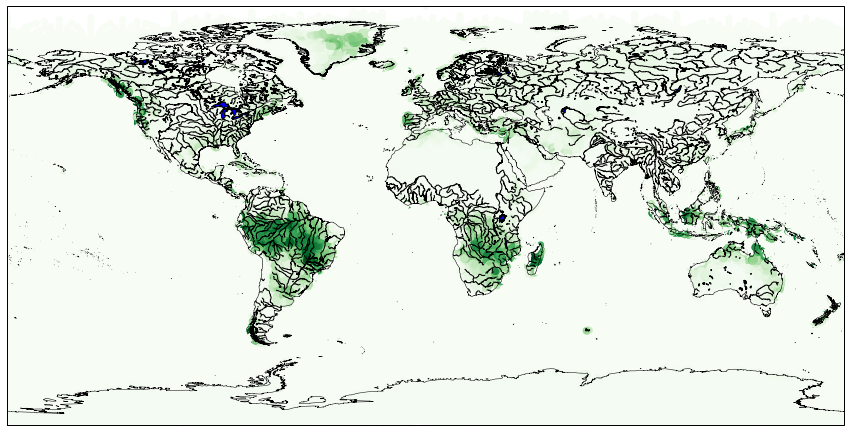

In [16]:
latitudes_in_radians  = mesh.tri.lats
longitudes_in_radians = mesh.tri.lons 
latitudes_in_degrees  = np.degrees(latitudes_in_radians) 
longitudes_in_degrees = np.degrees(longitudes_in_radians) 

map_extent = ( -180, 180, -90, 90 )

plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(map_extent)

ax.add_feature(coastline, edgecolor="black", linewidth=0.5, zorder=3)
ax.add_feature(lakes,     edgecolor="black", linewidth=1, zorder=3)
ax.add_feature(rivers   , edgecolor="black", facecolor="none", linewidth=1, zorder=3)

plt.scatter(x=longitudes_in_degrees, y=latitudes_in_degrees, c=rainfall.data, transform=ccrs.PlateCarree(),
            cmap='Greens',  vmin=0., vmax=50.)


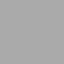

In [17]:
vertices = mesh.tri.points*mesh_height.reshape(-1,1)
tri = mesh.tri

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[600,600], near=-10.0)

tris = lv.triangles("mesh",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(vertices)
tris.indices(tri.simplices)
tris.values(mesh.topography.data, label="elevation")
tris.colourmap('geo', range=(6.363,6.377))  # This is a good choice of colourmap and range to make the coastlines work and the Earth look nice 
# tris.colourmap('drywet', range=(0.0,100)) # range=(6.363,6.377))  # This is a good choice of colourmap and range to make the coastlines work and the Earth look nice 

cb = tris.colourbar()

# sm = lv.points("submarine", colour="blue", pointsize=0.5, opacity=0.75)
# sm.vertices(vertices[submarine])

lv.control.Panel()
lv.control.ObjectList()
tris.control.Checkbox(property="wireframe")
lv.control.show()

In [72]:
low_points = mesh.identify_low_points(ref_height=6.37)

In [73]:
low_points.shape

(23,)

In [71]:

ref_height=6.37
mesh.low_points_local_patch_fill(its=3, smoothing_steps=3, ref_height=ref_height, fraction=0.1)

for repeat in range(0,50): 
    
    mesh.low_points_swamp_fill(ref_height=ref_height, its=5000, saddles=False, ref_gradient=1.0e-10, fluctuation_strength=0.01)
    mesh.low_points_local_patch_fill(its=1, smoothing_steps=0, ref_height=ref_height, fraction=0.01)
    mesh.low_points_swamp_fill(ref_height=ref_height, its=5000, saddles=False, ref_gradient=1.0e-10, fluctuation_strength=0.0)

    # In parallel, we can't break if ANY processor has work to do (barrier / sync issue)
    low_points3 = mesh.identify_global_low_points(ref_height=ref_height)

    print("{} : {}".format(repeat,low_points3[0]))
    if low_points3[0] == 0:
        break

low_points = mesh.identify_low_points(ref_height=ref_height)

Low point local patch fill
0 - Build downhill matrices 7.872857972979546s
0 - Build downhill matrices 5.20840148901334s
0 - Build downhill matrices 5.03628831700189s
Low point local patch fill  32.38680631300667  seconds
0 - Build upstream areas 52.71269926201785s
827  iterations, time =  46.882129439967684
Build low point catchments -  46.90919406298781  seconds
0  Sort spills -  0.005623664997983724
0  Gather spill data -  0.014187741035129875
0  Sort all spills -  0.0012313930201344192
0 - Build downhill matrices 5.542044654022902s
Low point swamp fill  55.83420248696348  seconds
0 - Build upstream areas 55.65778419596609s
Low point local patch fill
0 - Build downhill matrices 5.819855886977166s
Low point local patch fill  7.186117684002966  seconds
0 - Build upstream areas 62.34773681801744s
827  iterations, time =  51.04455903999042
Build low point catchments -  51.072783348034136  seconds
0  Sort spills -  0.004718425974715501
0  Gather spill data -  0.0007179529638960958
0  Sort

KeyboardInterrupt: 

In [32]:
runoff_var.data.max()

155.38027069693842

In [74]:
from quagmire import function as fn

ones = fn.parameter(1.0, mesh=mesh)
cumulative_flow_0 = np.log10(1.0e-20 + mesh.upstream_integral_fn(runoff_var).evaluate(mesh))
cumulative_flow_0[mesh_height < 6.37] = 0.0

cumulative_area = np.log10(1.0e-20 + mesh.upstream_integral_fn(ones).evaluate(mesh))
cumulative_area[mesh_height < 6.37] = 0.0


In [75]:
print(cumulative_flow_0.min(), cumulative_flow_0.max())
print(cumulative_area.min(), cumulative_area.max())

-20.0 14.040973536091549
0.0 12.762156636294337



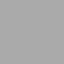

In [76]:
import lavavu
import stripy

vertices0 = mesh.tri.points*mesh_height.reshape(-1,1)
vertices = mesh.tri.points*mesh.topography.data.reshape(-1,1)
tri = mesh.tri

lv = lavavu.Viewer(border=False, axis=False, background="#FFFFFF", resolution=[1000,1000], near=-20.0)

lows = lv.points("lows", colour="red", pointsize=5.0, opacity=0.75)
lows.vertices(vertices[low_points])

flowball = lv.points("flowballs", pointsize=1.5, colour="rgb(50,50,100)", opacity=0.25)
flowball.vertices(vertices0)
flowball.values(np.maximum(0.0,cumulative_flow_0-11.0), label="flows")
flowball["sizeby"]="flows"

ghostball = lv.points("ghostballs", colour="rgb(50,50,50)", pointsize=0.25, opacity=0.5)
ghostball.vertices(vertices0)
ghostball.values(np.maximum(0.0,cumulative_area-8.0), label="areas")
ghostball["sizeby"]="areas"

heightball = lv.points("heightballs", pointsize=0.5, opacity=1.0)
heightball.vertices(vertices)
heightball.values(mesh.topography.data, label="height")
heightball.values((mesh.topography.data > 6.370).astype(float), label="land")
heightball.colourmap('geo',  range=(6.363,6.377))  # This is a good choice of colourmap and range to make the coastlines work and the Earth look nice 
heightball["sizeby"]="land"

tris = lv.triangles("mesh",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(vertices*1.0)
tris.indices(tri.simplices)
tris.values(mesh_height, label="elevation")
tris.colourmap('geo', range=(6.363,6.377))  # This is a good choice of colourmap and range to make the coastlines work and the Earth look nice 


# lv.translation(-1.012, 2.245, -13.352)
# lv.rotation(53.217, 18.104, 161.927)

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

In [79]:
mesh.save_mesh_to_hdf5("global_OC_8.4_mesh")
mesh.topography.save("global_OC_8.4_topography")
rainfall.save("global_OC_8.4_rainfall")
runoff_var.save("global_OC_8.4_runoff")
rawheight.save("global_OC_8.4_raw_topography")

In [ ]:
mesh.npoints

In [65]:
import h5py
fm = h5py.File(name="global_OC_8.4_mesh", mode='r')
ft = h5py.File(name="global_OC_8.4_topography", mode='r')

<KeysViewHDF5 []>